Welcome to JupyROOT 6.26/06

Initial number of events: 53900.00

Number of events passed MET > 200 GeV cut: 22021.42

Number of events passed Jet pT > 30 GeV, |eta| < 2.8 cut: 22004.58

Number of events passed number of jets <= 4 cut: 17474.56

Number of events passed delta phi > 0.4 (> 0.6 if 200 GeV < MET ≤ 250 GeV) cut: 17474.56

Number of events passed leading jet pT > 150 GeV, |eta| < 2.4 cut: 15549.16


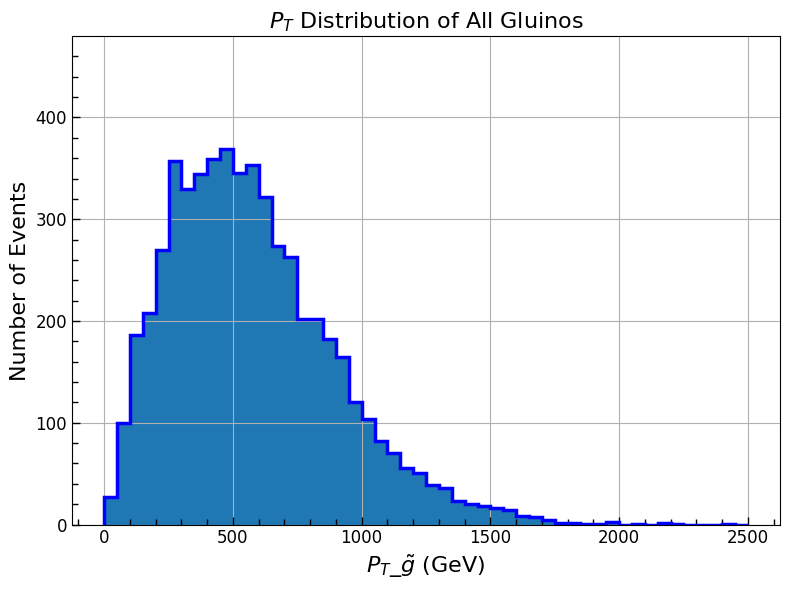

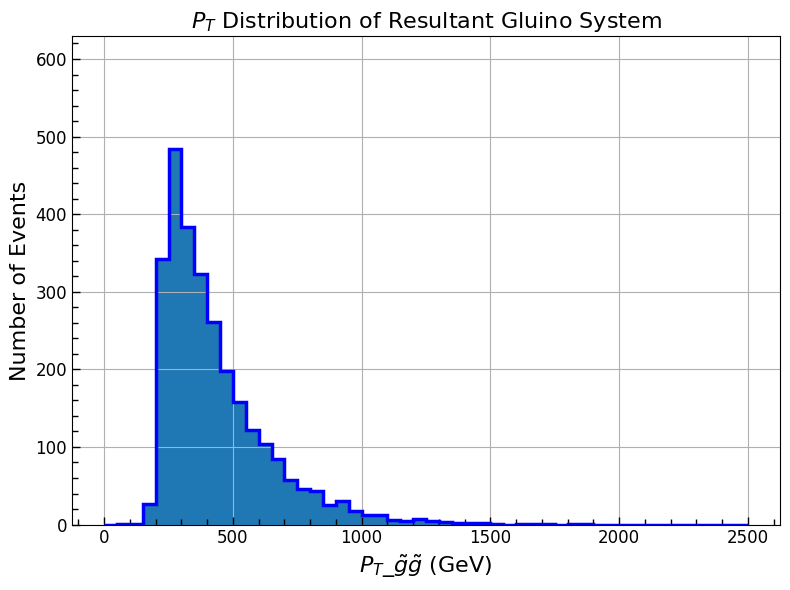

In [1]:
import ROOT
import matplotlib.pyplot as plt
import math

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

# Set the path to the ROOT file

home_dir = "root_files/MLM_N950/"
inputFile = home_dir + "tag_1_delphes_events.root"

# Create chain of root trees
chain = ROOT.TChain("Delphes")
chain.Add(inputFile)

# Create object of class ExRootTreeReader
treeReader = ROOT.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

# Get pointer to the branch containing Particle information
branchParticle = treeReader.UseBranch("Particle")
branchJet = treeReader.UseBranch("Jet")
branchMET = treeReader.UseBranch("MissingET")
branchEvent = treeReader.UseBranch("Event")

def delta_phi(phi1, phi2):
    dphi = abs(phi1 - phi2)
    return min(dphi, 2 * math.pi - dphi)
def calculate_delta_phi_jet_met(jet_phi, met_phi): return delta_phi(jet_phi, met_phi)

# Events Counter
initial_events = events_passed_met_cut = events_passed_pt_eta_cut = events_passed_jets_criteria = events_passed_delta_phi_cut = events_passed_leading_jet_cut = 0

#### Initial Cuts 
pt_cut = 30.0
max_eta = 2.8

gluino_pts = []
gluino_resultant_pts = []

# Constants for scaling
luminosity = 140.0 * 1000  # pb
cross_section = 0.385  # pb for gluino at 1 TeV https://twiki.cern.ch/twiki/bin/view/LHCPhysics/SUSYCrossSections13TeVgluglu
# W = σ * L * Wgen / ΣWgen. https://ipnp.cz/scheirich/?page_id=292

sum_event_weights = 0
for i in range(numberOfEntries):
    treeReader.ReadEntry(i)
    sum_event_weights += branchEvent.At(0).Weight

# Loop over all events
for entry in range(numberOfEntries):
    # Load selected branches with data from specified event
    treeReader.ReadEntry(entry)
    
    num_jets_meeting_criteria = leading_jet_pt =  leading_jet_eta = 0

    initial_events += branchEvent.At(0).Weight * luminosity * cross_section / sum_event_weights
    
    if branchMET.At(0).MET > 200:
        events_passed_met_cut += (branchEvent.At(0).Weight * luminosity * cross_section) / sum_event_weights
    
        # Loop over all jets
        for jet_index in range(branchJet.GetEntries()):
            jet = branchJet.At(jet_index)
        
            # Jet Pt and Eta Cuts
            if jet.PT > pt_cut and abs(jet.Eta) < max_eta:
                num_jets_meeting_criteria += 1
            
            # Save Leading Jet Pt and Eta
            if jet.PT > leading_jet_pt:
                leading_jet_pt = jet.PT
                leading_jet_eta = jet.Eta

        # Count events passing pt, eta cut
        if num_jets_meeting_criteria > 0:
            events_passed_pt_eta_cut += (branchEvent.At(0).Weight * luminosity * cross_section) / sum_event_weights
        
        # To set limit over jets
        if num_jets_meeting_criteria <= 4:
            events_passed_jets_criteria += (branchEvent.At(0).Weight * luminosity * cross_section) / sum_event_weights
            #print("Number of jets meeting criteria in event {}: {}".format(entry, num_jets_meeting_criteria)) #to check number of jets in each event
            
            #Delta_Phi cut implementation
            delta_phi_jet_met_min = 0.6 if 200 < branchMET.At(0).MET <= 250 else 0.4
            delta_phis = []
            for jet_index in range(branchJet.GetEntries()):
                jet = branchJet.At(jet_index)
                delta_phi_jet_met = calculate_delta_phi_jet_met(jet.Phi, branchMET.At(0).Phi)
                #delta_phi_jet_met = ROOT.TMath.Abs(ROOT.Math.VectorUtil.DeltaPhi(jet.Phi, branchMET.At(0).Phi))
                delta_phis.append(delta_phi_jet_met)
            
            # Check how many jets pass the delta_phi cut
            if any(delta_phi > delta_phi_jet_met_min for delta_phi in delta_phis):
                events_passed_delta_phi_cut += (branchEvent.At(0).Weight * luminosity * cross_section) / sum_event_weights
            
                # Leading Jets Pt and Eta cuts
                if leading_jet_pt > 150 and abs(leading_jet_eta) < 2.4:
                    events_passed_leading_jet_cut += (branchEvent.At(0).Weight * luminosity * cross_section) / sum_event_weights
                
                    gluino1_px = gluino1_py = gluino2_px = gluino2_py = 0
        
                    for particle_index in range(branchParticle.GetEntries()):
                        particle = branchParticle.At(particle_index)
                        if particle.PID == 1000021 and particle.Status == 62:   # Check if the particle is a gluino (PID=1000021) with status 62 (only two gluinos in each event)
                            gluino_pts.append(particle.PT)  # Store the PT of the gluino
                            # Store the Px and Py components of the first gluino
                            if gluino1_px == 0:  
                                gluino1_px = particle.Px
                                gluino1_py = particle.Py
                            # Store the Px and Py components of the second gluino
                            elif gluino2_px == 0:
                                gluino2_px = particle.Px
                                gluino2_py = particle.Py
                
                    # Calculate the PT of the resulting four-vector
                    resultant_px = gluino1_px + gluino2_px
                    resultant_py = gluino1_py + gluino2_py
                    resultant_pt = ROOT.TMath.Sqrt(resultant_px ** 2 + resultant_py ** 2)
                    gluino_resultant_pts.append(resultant_pt)

print(f"\nInitial number of events: {initial_events:.2f}")
print(f"\nNumber of events passed MET > 200 GeV cut: {events_passed_met_cut:.2f}")
print(f"\nNumber of events passed Jet pT > 30 GeV, |eta| < 2.8 cut: {events_passed_pt_eta_cut:.2f}")
print(f"\nNumber of events passed number of jets <= 4 cut: {events_passed_jets_criteria:.2f}")
print(f"\nNumber of events passed delta phi > 0.4 (> 0.6 if 200 GeV < MET ≤ 250 GeV) cut: {events_passed_delta_phi_cut:.2f}")
print(f"\nNumber of events passed leading jet pT > 150 GeV, |eta| < 2.4 cut: {events_passed_leading_jet_cut:.2f}")

# Plot the PT distribution of gluinos
plt.figure(figsize=(8, 6), dpi=100)
plt.hist(gluino_pts, bins=50, range=(0, 2500), histtype='step', color='blue', linewidth=2.5)
plt.xlabel('$P_T\_{\\tilde{g}}$ (GeV)', fontsize=16)
plt.ylabel('Number of Events', fontsize=16)
plt.title('$P_T$ Distribution of All Gluinos', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in', length=6, width=1)
plt.tick_params(which='minor', direction='in', length=4, width=1)
plt.minorticks_on()
plt.ylim(0, max(plt.hist(gluino_pts, bins=50, range=(0, 2500))[0]) * 1.3)

plt.tight_layout()
plt.show()


# Plot of PT distribution of gluino gluino system
plt.figure(figsize=(8, 6), dpi=100)
plt.hist(gluino_resultant_pts, bins=50, range=(0, 2500), histtype='step', color='blue', linewidth=2.5)
plt.xlabel('$P_T\_{\\tilde{g}\\tilde{g}}$ (GeV)', fontsize=16)
plt.ylabel('Number of Events', fontsize=16)
plt.title('$P_T$ Distribution of Resultant Gluino System', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in', length=6, width=1)
plt.tick_params(which='minor', direction='in', length=4, width=1)
plt.minorticks_on()
plt.tight_layout()
plt.ylim(0, max(plt.hist(gluino_resultant_pts, bins=50, range=(0, 2500))[0]) * 1.3)
plt.show()

%reset -f

